In [57]:
import geopandas as gpd
import pandas as pd
import os
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from shapely.geometry import Point
from pyproj import Transformer
import pystac_client
from pystac_client.stac_api_io import StacApiIO
import planetary_computer
import leafmap
import leafmap.colormaps
from shapely import wkt

In [2]:
config_path = '/home/benchuser/code/config.yml'
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
        
version = config['dataset']['version']
# version = 'v0.40.2'
working_dir = Path(config['directory']['working'])
output_dir = Path(config['directory']['output'])
aoi_version = config['aoi']['version']

print(yaml.dump(config))

aoi:
  exclude_indices: null
  include_indices: null
  version: v0.30
chips:
  chip_size: 960
  sample_size: 960
dataset:
  version: v0.40.7
dem:
  collection: cop-dem-glo-30
  dtype: float32
  fill_na: false
  na_value: -999
  native_crs: false
  resolution: 30
  year: 2021-01-02/2021-12-31
directory:
  output: /home/benchuser/final_data
  working: /home/benchuser/data
land_cover:
  collection: io-lulc-annual-v02
  dtype: int8
  fill_na: false
  na_value: 0
  native_crs: false
  resolution: 10
  sampling_factor: null
  year: 2023-01-02/2023-12-31
landsat:
  bands:
  - coastal
  - blue
  - green
  - red
  - nir08
  - swir16
  - swir22
  - qa_pixel
  cloud_band: qa_pixel
  cloud_cover: 100
  collection: landsat-c2-l2
  delta_days: 91
  dtype: float32
  fill_na: false
  na_value: -999
  native_crs: false
  platforms:
  - landsat-8
  - landsat-9
  resolution: 30
log_errors: true
sentinel_1:
  bands:
  - vv
  - vh
  collection: sentinel-1-rtc
  delta_days: 12
  dtype: float32
  fill_na: fa

In [3]:
metadata_filepath = Path(working_dir / version / 'chip_metadata.csv')

In [4]:
chip_df = pd.read_csv(metadata_filepath)

In [5]:
aoi_gdf = gpd.read_file(Path(working_dir) / version / 'aoi_metadata.geojson')
aoi_gdf['centroid'] = aoi_gdf.centroid
aoi_gdf.geometry = aoi_gdf['centroid']
print(Path(working_dir) / version / 'aoi_metadata.geojson')

/home/benchuser/data/v0.40.7/aoi_metadata.geojson


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/gfm_bench/share/proj failed


In [7]:
aoi_gdf

status                                           geometry  \
0    Internal Server Error  POLYGON ((21.64939 3.53375, 21.64939 3.45467, ...   
1    Internal Server Error  POLYGON ((18.96891 5.4779, 18.96891 5.44708, 1...   
2        s2 scenes missing  POLYGON ((8.28178 7.2393, 8.28178 7.211, 8.304...   
3        s1 scenes missing  POLYGON ((-2.53479 15.81157, -2.53479 15.42575...   
4                  success  POLYGON ((38.53933 9.3094, 38.53933 8.72942, 3...   
..                     ...                                                ...   
407          not processed  POLYGON ((-73.62022 45.57931, -73.62022 45.541...   
408          not processed  POLYGON ((-52.73406 47.56979, -52.73406 47.550...   
409          not processed  POLYGON ((-75.20969 20.14866, -75.20969 20.146...   
410          not processed  POLYGON ((-79.96607 22.40669, -79.96607 22.402...   
411          not processed  POLYGON ((-86.84232 21.1788, -86.84232 21.1730...   

                       centroid  
0      POINT (21.69238 3.49421)  
1      POINT (18.98749 5.46249)  
2       POINT (8.29336 7.22515)  
3     POINT (-2.33595 15.61866)  
4      POINT (38.80049 9.01941)  
..                          ...  
407   POINT (-73.59011 45.5604)  
408  POINT (-52.71739 47.56037)  
409  POINT (-75.20858 20.14756)  
410  POINT (-79.96356 22.40449)  
411  POINT (-86.83941 21.17592)  

[412 rows x 3 columns]

In [43]:
aoi_gdf['aoi_index'] = aoi_gdf.index

In [44]:
aoi_gdf['status'] = aoi_gdf['status'].map(lambda x: 'other error' if len(x) > 40 else x)

In [35]:
unique_statuses = list(aoi_gdf['status'].unique())
colors = leafmap.colormaps.get_palette('tab20', n_class=len(unique_statuses))
cmap = {status: f'#{color}' for status, color in zip(unique_statuses, colors)}
cmap['success'] = '#66FF00'
aoi_gdf['color'] = aoi_gdf['status'].map(lambda x: cmap[x])

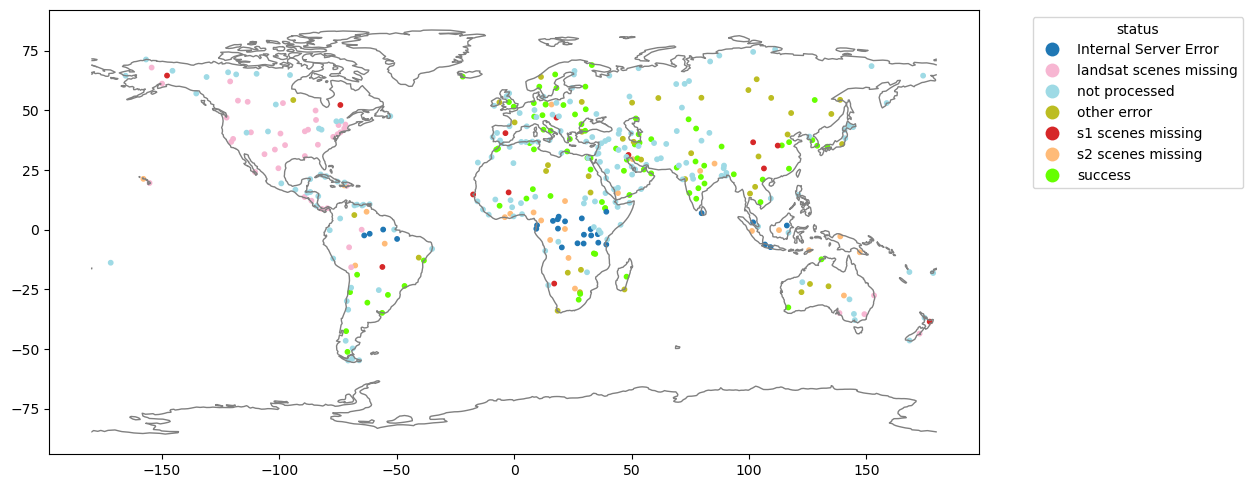

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))
coastline = gpd.read_file('https://raw.githubusercontent.com/martynafford/natural-earth-geojson/refs/heads/master/110m/physical/ne_110m_coastline.json')
coastline.plot(color='grey', linewidth = 1, ax=ax)

aoi_gdf['status'] = aoi_gdf['status'].astype('category')
ordered_colors = [cmap[k] for k in aoi_gdf['status'].cat.categories]
cmap = ListedColormap(ordered_colors)

aoi_gdf.plot(
    'status', 
    cmap=cmap, 
    ax=ax, 
    markersize=10, 
    legend=True, 
    legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left', 'title': 'status'}
)
# Show the plot
plt.show()

In [51]:
aoi_gdf.explore('status', cmap=cmap, marker_kwds={'radius':4})

<Axes: xlabel='status'>

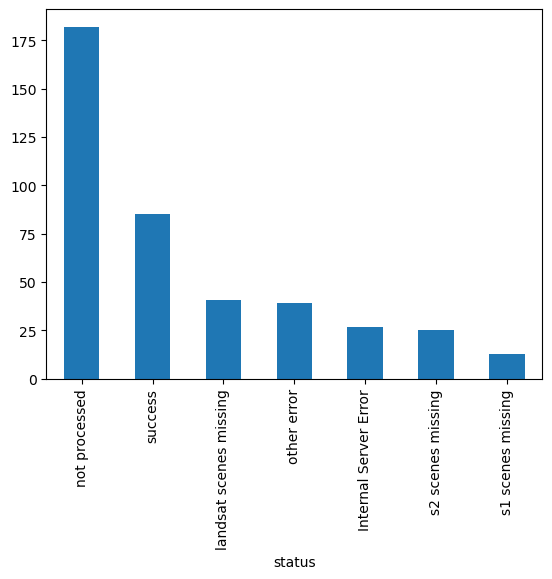

In [52]:
aoi_gdf['status'].value_counts().plot.bar()

In [53]:
len(aoi_gdf[aoi_gdf['status'] == 'success']) / len(aoi_gdf)

0.20631067961165048

In [54]:
pd.crosstab(chip_df['land_cover'], chip_df['status'], margins=True)

status      dem missing values  land_cover_11_limit  land_cover_1_limit  \
land_cover                                                                
1.0                      23054                    0               13461   
2.0                          0                    0                   0   
5.0                          7                    0                   0   
7.0                          0                    0                   0   
8.0                         28                    0                   0   
11.0                         3                64840                   0   
All                      23092                64840               13461   

status      land_cover_2_limit  land_cover_5_limit  land_cover_7_limit  \
land_cover                                                               
1.0                          0                   0                   0   
2.0                       6083                   0                   0   
5.0                          0                5902                   0   
7.0                          0                   0                 117   
8.0                          0                   0                   0   
11.0                         0                   0                   0   
All                       6083                5902                 117   

status      land_cover_8_limit  landsat missing values  \
land_cover                                               
1.0                          0                   29529   
2.0                          0                   15762   
5.0                          0                   13633   
7.0                          0                    4800   
8.0                      14661                    1643   
11.0                         0                   25783   
All                      14661                   91150   

status      sentinel_1 missing values  sentinel_2 missing values  success  \
land_cover                                                                  
1.0                                33                       1048     4145   
2.0                                60                        810     3647   
5.0                               309                       1386     9099   
7.0                                49                        225     1905   
8.0                                 9                        520     3073   
11.0                              305                       1687    11411   
All                               765                       5676    33280   

status         All  
land_cover          
1.0          71270  
2.0          26362  
5.0          30336  
7.0           7096  
8.0          19934  
11.0        104029  
All         259027

In [59]:
chip_df['chip_footprint_4326'] = gpd.GeoSeries(chip_df['chip_footprint'].dropna().map(wkt.loads), crs=4326)

In [60]:
chip_df = gpd.GeoDataFrame(chip_df, geometry = 'chip_footprint_4326', crs=4326)
chip_df['land cover and error'] = chip_df['land_cover'].astype(str) + '_' + chip_df['status']

In [62]:
aoi = 127

In [63]:
chip_df[chip_df['aoi_index'] == aoi].explore('land cover and error', tiles="http://mt0.google.com/vt/lyrs=s&hl=en&x={x}&y={y}&z={z}", attr="Google", marker_kwds=dict(radius=5))


In [87]:
land_cover_cmap = {
    "1": "#419bdf",  # Water
    "2": "#397d49",  # Trees
    "4": "#7a87c6",  # Flooded Vegetation
    "5": "#e49635",  # Crops
    "7": "#c4281b",  # Built Area
    "8": "#a59b8f",  # Bare Ground
    "9": "#a8ebff",  # Snow/Ice
    "10": "#616161",  # Clouds
    "11": "#e3e2c3"   # Rangeland
}

border_color_dict = {
    'success': '#66FF00',
    'landsat missing values': '#FFFFFF',
}

In [88]:
def get_color_from_status(land_cover: float):
    land_cover_string = str(land_cover).split('.')[0]
    hex_color = land_cover_cmap.get(land_cover_string, '#000000')
    return hex_color
def get_border_from_status(status: str):
    border_color = border_color_dict.get(status, '#000000')
    return border_color

In [89]:
callback = lambda feat: {
    "color": feat['properties']['border_color'],
    "weight": 2,
    "fillColor": feat['properties']['color'],
    "fillOpacity": 1
}
m = leafmap.Map()
aoi_chips = chip_df[chip_df['aoi_index'] == aoi]
aoi_chips['color']=aoi_chips['land_cover'].apply(lambda x: get_color_from_status(x))
aoi_chips['border_color']=aoi_chips['status'].apply(lambda x: get_border_from_status(x))
m.add_gdf(
    aoi_chips,
    style_callback=callback,
    layer_name=f"Chip Footprints (AOI {aoi})",
    zoom_to_layer=True,
)

In [82]:
stac_items = gpd.read_file(Path(working_dir) / version / f"{aoi}_stac_items.json")

Skipping field instruments: unsupported OGR type: 5
Skipping field s1:shape: unsupported OGR type: 1
Skipping field proj:bbox: unsupported OGR type: 3
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 3
Skipping field sar:polarizations: unsupported OGR type: 5


In [83]:
# initialize pystac client with retry policy
stac_api_io = StacApiIO()
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

In [84]:
supercell_ids = list(stac_items['supercell'].dropna().unique())
search = catalog.search(
    collections='io-lulc-annual-v02',
    datetime = '2023-01-02/2023-12-31',
    query = {
        'supercell' : {'in': supercell_ids}
    }
)
items = search.item_collection()

In [91]:
for item in items:
    url = item.assets['data'].href
    m.add_cog_layer(url, colormap = land_cover_cmap, zoom_to_layer=False)

In [92]:
m

Map(bottom=38319.0, center=[60.06072840894273, 30.60653686523438], controls=(ZoomControl(options=['position', …

## Move a Sample of Chips

In [93]:
def get_first_n_chips(n, chip_df):
    success_chips = chip_df[chip_df['status'] == 'success']
    success

In [95]:
success_chips = chip_df[chip_df['status'] == 'success']

In [96]:
success_sample = success_chips.head(50)

In [101]:
chip_indices = [str(index).zfill(6) for index in success_sample.chip_index]

In [102]:
chip_indices

['000012',
 '000019',
 '000020',
 '000021',
 '000022',
 '000023',
 '000024',
 '000025',
 '000026',
 '000027',
 '000034',
 '000035',
 '000037',
 '000041',
 '000048',
 '000050',
 '000052',
 '000053',
 '000056',
 '000059',
 '000060',
 '000065',
 '000066',
 '000067',
 '000070',
 '000078',
 '000079',
 '000084',
 '000085',
 '000090',
 '000094',
 '000095',
 '000096',
 '000097',
 '000101',
 '000102',
 '000103',
 '000106',
 '000107',
 '000108',
 '000113',
 '000115',
 '000119',
 '000123',
 '000124',
 '000125',
 '000126',
 '000128',
 '000131',
 '000132']

In [115]:
working_dir / version

PosixPath('/home/benchuser/data/v0.40.7')

In [122]:
def find_chip_files(indices: list[str], data_dir: Path) -> list[Path]:

    indices_set = set(indices)
    matching_files = []
    
    all_chip_files = data_dir.glob('*_*.*')

    for file_path in all_chip_files:
        chip_id = file_path.stem.split('_')[1]
        if chip_id in indices_set:
            matching_files.append(file_path)
            
    return matching_files


In [133]:
sample_file_paths = find_chip_files(chip_indices, (working_dir / version))

In [134]:
sample_file_paths

[PosixPath('/home/benchuser/data/v0.40.7/landsat_000106_0_20230220.png'),
 PosixPath('/home/benchuser/data/v0.40.7/landsat_000102_1_20230620.tif'),
 PosixPath('/home/benchuser/data/v0.40.7/lc_000096.tif'),
 PosixPath('/home/benchuser/data/v0.40.7/lc_000097.tif'),
 PosixPath('/home/benchuser/data/v0.40.7/landsat_000123_1_20230620.png'),
 PosixPath('/home/benchuser/data/v0.40.7/landsat_000019_2_20230916.png'),
 PosixPath('/home/benchuser/data/v0.40.7/landsat_000060_0_20230220.tif'),
 PosixPath('/home/benchuser/data/v0.40.7/landsat_000020_1_20230620.png'),
 PosixPath('/home/benchuser/data/v0.40.7/landsat_000107_0_20230220.png'),
 PosixPath('/home/benchuser/data/v0.40.7/lc_000021.tif'),
 PosixPath('/home/benchuser/data/v0.40.7/dem_000103.tif'),
 PosixPath('/home/benchuser/data/v0.40.7/landsat_000027_1_20230620.png'),
 PosixPath('/home/benchuser/data/v0.40.7/lc_000026.tif'),
 PosixPath('/home/benchuser/data/v0.40.7/landsat_000106_3_20231205.tif'),
 PosixPath('/home/benchuser/data/v0.40.7/la

In [135]:
dest_directory = working_dir / f'sample_chips_{version}'
dest_directory.mkdir(exist_ok=True)

In [136]:
import shutil
for sample_file_paths in sample_file_paths:
    shutil.copy(sample_file_paths, dest_directory)


In [138]:
output_zip_file = working_dir / f'sample_chips_{version}'
shutil.make_archive(output_zip_file, 'zip', dest_directory)


'/home/benchuser/data/sample_chips_v0.40.7.zip'